In [118]:
import cv2
import torch
import random
import csv

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

## 1. Data Preprocessing

In [119]:
# 脸部范围扩大

def expand_roi(face_list, ratio, img_url):
    """
    face_list: 脸部范围 [x1, y1, x2, y2]
    ratio: 放大比例
    img_url: 图片地址
    """
    img = cv2.imread(img_url)
    img_height, img_width = img.shape[:2]
    x1, y1, x2, y2 = [int(float(i)) for i in face_list]
    
    width = x2 - x1 + 1
    height = y2 - y1 + 1
    padding_width = int(width * ratio)
    padding_height = int(height * ratio)
    
    roi_x1 = x1 - padding_width
    roi_y1 = y1 - padding_height
    roi_x2 = x2 + padding_width
    roi_y2 = y2 + padding_height
    roi_x1 = 0 if roi_x1 < 0 else roi_x1
    roi_y1 = 0 if roi_y1 < 0 else roi_y1
    roi_x2 = img_width - 1 if roi_x2 >= img_width else roi_x2
    roi_y2 = img_height - 1 if roi_y2 >= img_height else roi_y2
    
    return [roi_x1, roi_y1, roi_x2, roi_y2]

In [120]:
floder_path = ['./项目二/data/I/', './项目二/data/II/']
radio = 0.9

# obs_path = ['s3://cnn-data-train/data_keypoint/I/', 's3://cnn-data-train/data_keypoint/II/']


def creat_train_test(floder_path, radio):
    data = {'train':[], 'test':[]}
    
    f1 = open('train.csv','w',newline='',encoding='utf-8-sig')
    f2 = open('test.csv','w',newline='',encoding='utf-8-sig')
    train = csv.writer(f1)
    test = csv.writer(f2)

    for i, url in enumerate(floder_path):
        with open((url + 'label.txt')) as f:
            lines = f.readlines()

            for line in lines:
                line = line.split()

                img_url = url + line[0]
                line[1: 5] = expand_roi(line[1: 5], 0.25, img_url)
                line[5:] = [float(i) for i in line[5:]]
#                 line[0] = obs_path[i] + line[0]
                line[0] = url + line[0]
          

                p = random.uniform(0, 1)
                
                if p < radio:
                    data['train'].append(line)
                    train.writerow(line)
                else:
                    data['test'].append(line)
                    test.writerow(line)


    f1.close()
    f2.close()

    for i in ['train', 'test']:
        print(f'{i} nums: {len(data[i])}')
    
    return data

data = creat_train_test(floder_path, radio)



train nums: 2504
test nums: 282


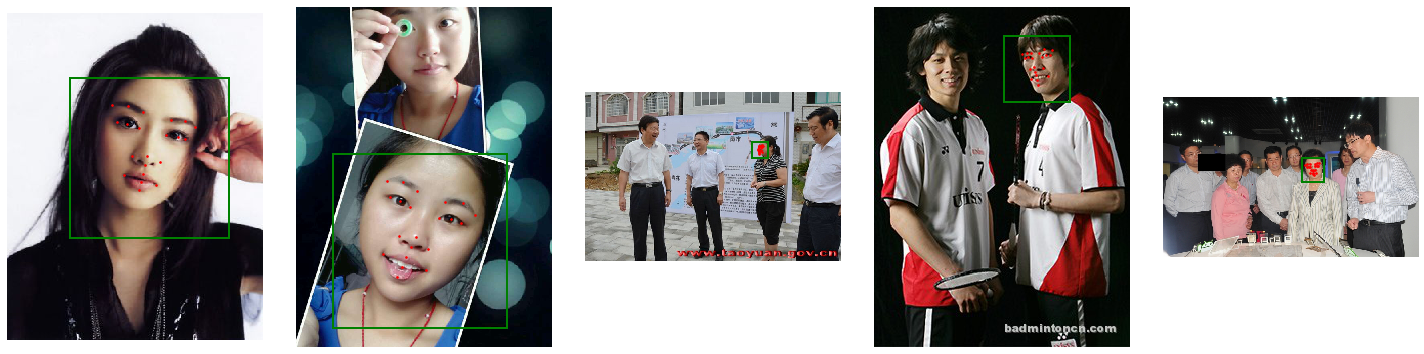

In [104]:
def my_show(data, nums, figsize=(20, 10)):
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        n = random.randint(1, 1200)
        img_data = data[n]
        ax.axis('off')
    
        # 图片展示
        img_url = img_data[0]
        
        img = cv2.imread(img_url)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        # 人脸矩形展示
        x1, y1, x2, y2 = img_data[1: 5]
        rect = plt.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        # 特征点展示
        landmarks_X = img_data[5::2]
        landmarks_Y = img_data[6::2]
        ax.scatter(landmarks_X, landmarks_Y, s=10, marker='.', c='r')


my_show(data=data['train'], nums=5)

## 2. Dataset

In [105]:
class FaceLandmarksDataset(Dataset):
    """
    1. 根据脸部大小剪裁图片
    2. 调整landmarks，减去rect第一个点
    3. 图片有黑白，所以为了保持统一channel，全部调整为灰度图
    """
    def __init__(self, data, transform=None):
        self.lines = data
        self.transform = transform
        
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        line = self.lines[idx]
        img_name, rect, landmarks = line[0], line[1: 5], line[5:]
        
        # 人脸范围剪裁
        img = Image.open(img_name).convert('RGB')
        img_crop = img.crop(rect)

        # 标准化标记点
        landmarks = np.asarray(landmarks, dtype=np.float32).reshape(-1, 2)
        landmarks -= rect[:2]
        
        sample = {'image': img_crop, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [108]:
# Transform

class Crop_Risize:
    """
    resize
    1. 剪裁用PIL.resize, 参数：Image.ANTIALIAS，保留更多信息
    
    normalize landmarks
    2. 用两张图的角点，得到映射矩阵，然后做点积
    3. 映射矩阵维度(3, 3)，所以landmarks调整维度(n, 3)，补1
    4. 最后降维，因为model输出是1维
    """
    def __call__(self, sample, train_boarder=112):
        image, landmarks = sample['image'], sample['landmarks']
        # PIL 解析 H * W * C
        image_width, image_height = image.size
        image = image.resize((train_boarder, train_boarder),Image.BILINEAR)
        
        # Image.ANTIALIAS
        # 标准化landmarks
        landmarks[:, 0] = landmarks[:, 0] * train_boarder / image_width
        landmarks[:, 1] = landmarks[:, 1] * train_boarder / image_height
        landmarks = landmarks.ravel()
        
#         pts1 = np.float32([[0,0],[0,image_height],[image_width,0],[image_width,image_height]])  
#         pts2 = np.float32([[0,0],[0,train_boarder],[train_boarder,0],[train_boarder,train_boarder]])  

#         M = cv2.getPerspectiveTransform(pts1,pts2)

#         landmarks = np.hstack((landmarks, np.ones((landmarks.shape[0],1))))
#         landmarks = np.dot(landmarks, M)
#         landmarks, _ = np.split(landmarks, [2], axis=1)
#         landmarks = landmarks.ravel()

        return {'image': image, 'landmarks': landmarks}
        
        
class ToTensor:
    """
    1. 数据和标签保持dtype一致, 默认float32
    """
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
#         image = np.expand_dims(image, axis=0)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        landmarks = torch.from_numpy(landmarks).float()

        return {'image': image, 'landmarks': landmarks}

    
class Normalize:
    """
    1. 不加normalize，Adam优化时，loss会nan
    """
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = np.asarray(image, dtype=np.float32)
#         image = (image - np.mean(image)) / (np.std(image) + 1e-7)
        image /= 255.0
        landmarks /= 112
        
        return {'image': image, 'landmarks': landmarks}
    

In [111]:
# 用transforms.Compose封装需要用到的转化的类
tsfm = transforms.Compose([Crop_Risize(), Normalize(), ToTensor()])

# dataset分两部分训练集与验证集
train_set = FaceLandmarksDataset(data['train'], transform=tsfm)
valid_set = FaceLandmarksDataset(data['test'], transform=tsfm)

# 用来数据检验的，就没用到 Normalize(), ToTensor()两个类
img_show = FaceLandmarksDataset(data['train'], transform=Crop_Risize())


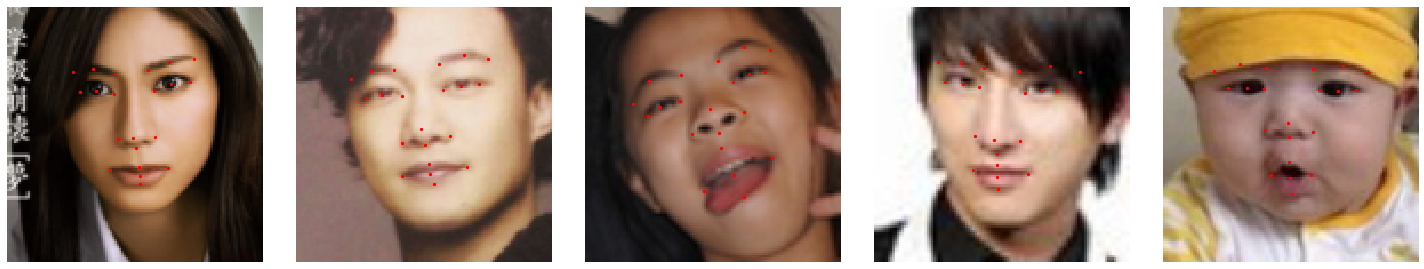

In [112]:
# 数据可视化展示

def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(1, 1200)
        img, landmarks = data[n].values()
#         landmarks = data[n]['landmarks']
        
        X = landmarks[0::2]
        Y = landmarks[1::2]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
my_show(img_show, 5)

## 3. Model

In [123]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # in_channel, out_channel, kernel_size, stride, padding
        self.conv1_1 = nn.Conv2d(3, 8, 5, 2, 0)
        self.conv2_1 = nn.Conv2d(8, 16, 3, 1, 0)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, 0)
        self.conv3_1 = nn.Conv2d(16, 24, 3, 1, 0)
        self.conv3_2 = nn.Conv2d(24, 24, 3, 1, 0)
        self.conv4_1 = nn.Conv2d(24, 40, 3, 1, 1)
        self.conv4_2 = nn.Conv2d(40, 80, 3, 1, 1)
        
        self.ip1 = nn.Linear(4 * 4 * 80, 128)
        self.ip2 = nn.Linear(128, 128)
        self.ip3 = nn.Linear(128, 42)
        
        self.prelu = nn.PReLU()
        
        self.ave_pool = nn.AvgPool2d(2, 2, ceil_mode=True)
        
    def forward(self, x):
        x = self.ave_pool(self.prelu(self.conv1_1(x)))
                                    # in：32*3*112*112  out：32*8*27*27
                                    # conv: (112 - 5) // 2 + 1 = 54  pooling: 52 / 2 = 27
        x = self.prelu(self.conv2_1(x))
                                    # out: 32*16*25*25
        x = self.prelu(self.conv2_2(x))
                                    # out: 32*16*23*23
        x = self.ave_pool(x)
                                    # out: 32*16*12*12
        x = self.prelu(self.conv3_1(x))
                                    # out: 32*24*10*10
        x = self.prelu(self.conv3_2(x))
                                    # out: 32*24*8*8
        x = self.ave_pool(x)
                                    # out: 32*24*4*4
        x = self.prelu(self.conv4_1(x))
                                    # out: 32*40*4*4
        # stage 3 branch
        x = self.prelu(self.conv4_2(x))
                                    # out: 32*80*4*4
        # FC
        x = x.view(-1, 4 * 4 * 80)
                                    # out: 32*1280
        ip1 = self.prelu(self.ip1(x))
                                    # out: 32*128
        ip2 = self.prelu(self.ip2(ip1))
                                    # out: 32*128
        ip3 = self.prelu(self.ip3(ip2))
                                    # out: 32*42   (21组坐标点)
        return ip3
    

## 4. Train

In [142]:
# 超参数调整
lr = 0.001
batch_size = 128
momentum = 0.9
epoch = 5

# 定义模型
model = Net()
# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer_adam = optim.Adam(model.parameters())

# 用DataLoader，载入Dateset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)



In [145]:
# 训练模型

def train(train_loader, valid_loader, model, criterion, optimizer, epoch):
    train_loss_lst = []
    valid_loss_lst = []
    
    for epoch_idx in range(epoch):
        # Training the model
        train_totle_loss = 0.0
        times = 0
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            # 载入数据
            input_img = batch['image']
            target_pts = batch['landmarks']
            
            # 前向传播，求loss
            output_pts = model(input_img)
            loss = criterion(output_pts, target_pts)
            
            # 梯度清零，loss反向传播，更新权重
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_totle_loss += loss.item()
            times += 1
        train_totle_loss /= times
            
            # 打印结果
        if epoch_idx % 5 == 0:
            print('Train: pts_loss: {:.4f}'.format(train_totle_loss))
        train_loss_lst.append(train_totle_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            valid_totle_loss = 0.0
            times = 0
            for valid_batch_idx, batch in enumerate(valid_loader):
                input_img = batch['image']
                target_pts = batch['landmarks']
                
                output_pts = model(input_img)
                valid_loss = criterion(output_pts, target_pts)
                
                valid_totle_loss += valid_loss.item()
                times += 1

        valid_mean_loss = valid_totle_loss / times
            
        if epoch_idx % 5 == 0:
            print('Valid: pts_loss: {:.4f}'.format(valid_mean_loss))
            print('=' * 20)
        valid_loss_lst.append(valid_mean_loss)

    # 保存模型
    torch.save(model, './stage_1.pth')
    
    return train_loss_lst, vaild_loss_lst
    

In [ ]:
train_loss, valid_loss = train(train_loader, valid_loader, model, criterion, optimizer_adam, epoch=100)


Train: pts_loss: 0.0055
Valid: pts_loss: 0.0032
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0024
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0021
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0024
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0025
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0021
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0023
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0024
Train: pts_loss: 0.0026
Valid: pts_loss: 0.0027


In [ ]:
test_model = torch.load('./stage_1.pth')
test_model.eval()

with torch.no_grad():
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
#     test = next(iter(test_loader))
    test = next(iter(train_loader))
    image, landmarks = test.values()
    outputs = test_model(image)

    loss = criterion(outputs, landmarks)
    print(loss.item())

In [ ]:
def my_show(image, landmarks, nums):
    fig = plt.figure(figsize=(20, 5))
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, batch_size)

        img = image[n].numpy() * 255
        img = img.astype('uint8')
        img = img.transpose((1, 2, 0))
        lan = landmarks[n].numpy() * 112
        lan = lan.reshape(-1, 2)
        
        X = lan[:, 0]
        Y = lan[:, 1]
        ax.scatter(X, Y, s=20, marker='.', c='r')
        ax.imshow(img)
        ax.axis('off')
        
my_show(image, outputs, 5)
